In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import sys
# ajout du chemin src
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path: sys.path.append(project_root)
from src.data_prep import load_and_feature_engineering, reduce_mem_usage, missing_values_table

In [2]:
# visualisation des fichier data
print(os.listdir("../data/"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [3]:
# Cela appelle notre fonction .py qui fait les ratios + les jointures "light"
df = load_and_feature_engineering()

--- Chargement et Préparation des Données ---
Base Train chargée: (307511, 122)
Creation des features métier (Domain Knowledge)...
Après get_bureau_features: (307511, 134)
Après get_previous_features: (307511, 137)
Après get_pos_cash_features: (307511, 140)
Après get_installments_features: (307511, 143)
--- Terminé ---


In [4]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,BUREAU_CREDIT_ACTIVE_BINARY_MEAN,PREV_AMT_ANNUITY_MEAN,PREV_APP_REFUSED_MEAN,PREV_CNT_PAYMENT_MEAN,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_CNT_INSTALMENT_FUTURE_SUM,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_MAX
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.25,9251.775,0.000000,24.000000,0.0,0.0,285.0,0.000,0.000000,-49.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.25,56553.990,0.000000,10.000000,0.0,0.0,162.0,0.000,0.000000,-544.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.00,5357.250,0.000000,4.000000,0.0,0.0,9.0,0.000,0.000000,-727.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,23651.175,0.111111,23.000000,0.0,0.0,173.0,0.000,0.000000,-12.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.00,12278.805,0.000000,20.666667,0.0,0.0,592.0,29857.365,452.384318,-14.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 143 entries, SK_ID_CURR to INSTAL_DAYS_ENTRY_PAYMENT_MAX
dtypes: float64(86), int64(41), object(16)
memory usage: 335.5+ MB


In [6]:
# Réduction de la taille mémoire
df = reduce_mem_usage(df)

Usage mémoire initial du DataFrame: 335.50 MB
Usage mémoire final du DataFrame: 109.39 MB
Mémoire réduite de 67.4 %


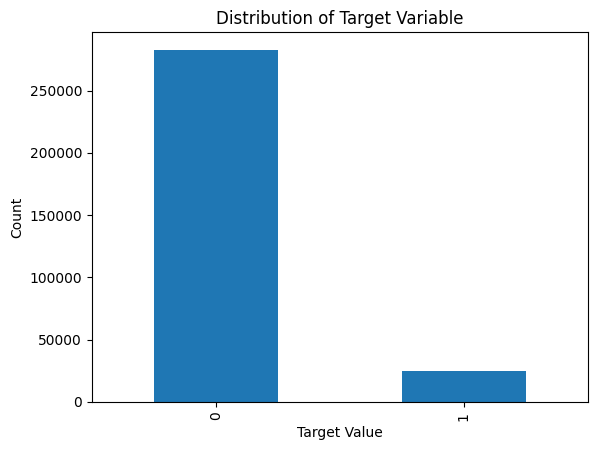

In [7]:
# Visualisation de la distribution de la variable cible
df['TARGET'].value_counts().plot(kind='bar')
plt.title('Distribution of Target Variable')
plt.xlabel('Target Value')
plt.ylabel('Count')
plt.show()

In [9]:
# Missing values statistics
missing_values = missing_values_table(df)
missing_values.head(20)

Your selected dataframe has 143 columns.
There are 86 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_MEDI,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4


In [10]:
#On enleve l'id et on le met en index pour pas le prendre en compte
if 'SK_ID_CURR' in df.columns:
    df.set_index('SK_ID_CURR', inplace=True) 

#on enleve aussi target des features d'entrainement
y = df['TARGET']
X = df.drop(columns=['TARGET'])
print("Shape X:", X.shape)
print("Shape y:", y.shape)

Shape X: (307511, 141)
Shape y: (307511,)


In [12]:
# On encode avec get_dummies (One-Hot encoding)
X = pd.get_dummies(X, dummy_na=True) # dummy_na=True crée une colonne "Nan" si la valeur manque 

print(f"Shape X après encodage : {X.shape}")

Shape X après encodage : (307511, 281)


In [15]:
# Calcul de la corrélation 
correlations = df.select_dtypes(include=[np.number]).corr()['TARGET'].sort_values()

# Affichage des corrélations les plus fortes (positives et négatives)
print("Top 10 : Corrélations Positives (Augmente le risque de défaut)")
print(correlations.tail(10))

print("\nTop 10 : Corrélations Négatives (Diminue le risque de défaut)")
print(correlations.head(10))

Top 10 : Corrélations Positives (Augmente le risque de défaut)
REG_CITY_NOT_WORK_CITY              0.050994
DAYS_ID_PUBLISH                     0.051457
DAYS_LAST_PHONE_CHANGE              0.055219
REGION_RATING_CLIENT                0.058899
REGION_RATING_CLIENT_W_CITY         0.060893
BUREAU_CREDIT_ACTIVE_BINARY_MEAN    0.077357
PREV_APP_REFUSED_MEAN               0.077672
DAYS_BIRTH                          0.078239
BUREAU_DAYS_CREDIT_MEAN             0.089729
TARGET                              1.000000
Name: TARGET, dtype: float64

Top 10 : Corrélations Négatives (Diminue le risque de défaut)
EXT_SOURCE_3                 -0.178918
EXT_SOURCE_2                 -0.160471
EXT_SOURCE_1                 -0.155318
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044005
FLOORSMAX_MEDI               -0.043769
FLOORSMAX_MODE               -0.043228
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037231
PREV_AMT_ANNUITY_MEAN        -0.034871
Name:

In [ ]:
# Gestion des valeurs manquantes. pour le moment on fait rien car lightGBM est sencé les géré on verra si necessaire apres

# for col in X.select_dtypes(include=np.number):
#     X[col] = X[col].fillna(X[col].median())


In [13]:
# Split des données
# Stratify=y est OBLIGATOIRE car les classes sont déséquilibrées (8% de défauts)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (246008, 281)
Test shape: (61503, 281)


In [14]:
# On sauvegarde en format Pickle (beaucoup plus rapide que CSV et garde les types de données)
X_train.to_pickle('../data/X_train.pkl')
X_test.to_pickle('../data/X_test.pkl')
y_train.to_pickle('../data/y_train.pkl')
y_test.to_pickle('../data/y_test.pkl')

print("Fichiers sauvegardés dans data/ !")

Fichiers sauvegardés dans data/ !
